# ◈ 데이터 분석 준비

## 1) Colab 환경 설정

In [ ]:
# 시각화 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 트리맵
!pip install squarify

# 요인분석
!pip install pingouin factor_analyzer

# 연관분석
!pip install -U apyori mlxtend

## 2) 필수 라이브러리 로드

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from patsy import demo_data, dmatrix, dmatrices

## 3) 글로벌 환경 설정

In [ ]:
#%precision 3 # np 정확도를 소숫점 3자리로 고정
%matplotlib inline
sns.set_theme()

# plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

sns_color = sns.color_palette('pastel')
plt_line = ['-', '--', ':', '-.']

## 4) 분석 데이터 로드

In [ ]:
mtcars = pd.read_csv('https://github.com/ksky1313/ADP/raw/main/data/mtcars.csv')
mtcars.drop(columns=mtcars.columns[0], inplace=True)

df = mtcars
df.head(3)

,carname,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1


# ◈ 확률분포

## 1) 정규분포
- 좌우 대칭, 평균 0, 표준편차 1

In [ ]:
rn = stats.norm(0, 1)
print(rn.isf(0.1)) # 상위 10%점

1.2815515655446004


## 2) 카이제곱분포
- 좌우비대칭(왼쪽 치우침), 자유도값 근처에서 정점, 자유도가 커지면 좌우대칭에 가까움

In [ ]:
rx = stats.chi2(5) # 자유도가 5인 카이제곱 분포
print(rx.isf(0.1)) # 상위 10%점

9.236356899781116


## 3) T 분포
- 좌우대칭, 표준정규분포보다 양쪽끝이 두꺼움, 자유도 커지면 표준정규분포에 가까움

In [ ]:
rt = stats.t(5) # 자유도가 5인 T 분포
print(rt.isf(0.1)) # 상위 10%점

1.475884048782027


## 4) F 분포
- 좌우비대칭(왼쪽 치우침), 분포의 정점은 1에 근사

In [ ]:
rf = stats.f(5, 10) # 자유도가 5, 10인 F분포
print(rf.isf(0.1)) # 상위 10%점

2.521640686209624


# ◈ 정규성 검정

## 1) Shapiro Wilk
- 가장 엄격, 표본수가 적을때(50개 미만)

In [ ]:
stat, pvalue = stats.shapiro(df['mpg'])
print(f'[shapiro] (H0)정규분포에 따른다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[shapiro] (H0)정규분포에 따른다: True, pvalue = 0.1229


## 2) Kolmogorov Shirnov
- 표본수가 많을때, 2개 분포의 동질성 확인

In [ ]:
stat, pvalue = stats.kstest(df['mpg'], 'norm')
print(f'[kstest] (H0)정규분포에 따른다: ㅁ{pvalue>0.05}, pvalue = {pvalue:.4f}')

[kstest] (H0)정규분포에 따른다: False, pvalue = 0.0000


## 3) D'Agostino's K-squared test

In [ ]:
stat, pvalue = stats.mstats.normaltest(df['mpg'])
print(f'[normaltest] (H0)정규분포에 따른다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[normaltest] (H0)정규분포에 따른다: True, pvalue = 0.2574


## 4) 시각화 : Q-Q Plot

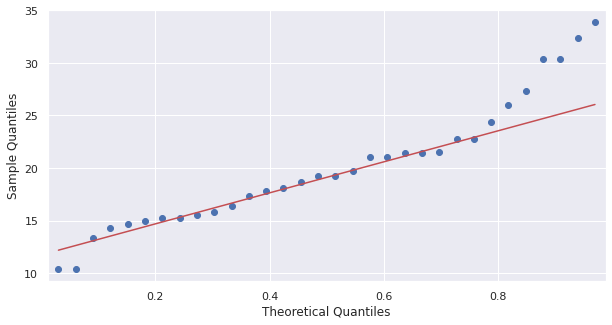

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sm.qqplot(
    df['mpg'], 
    line='q', 
    dist=stats.uniform, 
    ax=ax
    );

# ◈ 등분산성 검정
- 모집단 또는 요인 수준 간 분산의 동일성을 검정

## 1) levene

In [ ]:
mpg_cyl4 = df.loc[df.cyl==4, 'mpg']
mpg_cyl6 = df.loc[df.cyl==6, 'mpg']
mpg_cyl8 = df.loc[df.cyl==8, 'mpg']

stat, pvalue = stats.levene(mpg_cyl6, mpg_cyl8)
print(f'[levene] (H0)등분산이다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[levene] (H0)등분산이다: True, pvalue = 0.4174


## 2) fligner

In [ ]:
stat, pvalue = stats.fligner(mpg_cyl6, mpg_cyl8)
print(f'[fligner] (H0)등분산이다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[fligner] (H0)등분산이다: True, pvalue = 0.5490


## 3) bartlett

In [ ]:
stat, pvalue = stats.bartlett(mpg_cyl4, mpg_cyl6, mpg_cyl8)
print(f'[bartlett] (H0)등분산이다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[bartlett] (H0)등분산이다: False, pvalue = 0.0150


# ◈ T-검정

| 그룹 | 모수적 방법 | 비모수적 방법 |
| --- | --- | --- |
| 2개 | T-Test | Wilcoxon Rank sum Test |
| 3개 | ANOVA | Kruskal-Wallis Test |


## 1) 일표본 T-검정
- 정규성을 만족하지 못한 상태에서 T검정을 실시하면 1종 오류 값이 커지거나 신뢰성 저하되므로 수행전에 정규성 검정(샤피로 윌크)를 선행해야 함
- 정규성을 만족하지 못하면 비모수검정을 실시하는게 바람직

In [ ]:
# 정규성 검증
stat, pvalue = stats.shapiro(df['mpg'])
print(f'[shapiro] (H0)정규분포에 따른다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

# 일표본 T-검정
stat, pvalue = stats.ttest_1samp(df.mpg, popmean=20)
print(f'[ttest_1samp] (H0)검정 평균과 같다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[shapiro] (H0)정규분포에 따른다: True, pvalue = 0.1229
[ttest_1samp] (H0)검정 평균과 같다: True, pvalue = 0.9328


## 2) 대응표본 T-검정

In [ ]:
#10명의 환자를 대상으로 수면영양제를 복용하기 전과 후의 수면시간을 측정하여 영양제의 효과가 있는지를 판단
tmp = pd.DataFrame({'before': [7, 3, 4, 5, 2, 1, 6, 6, 5, 4], 'after' :[8, 4, 5, 6, 2, 3, 6, 8, 6, 5]})

# 정규성 검증
stat, pvalue = stats.shapiro(tmp['before'])
print(f'[shapiro] (H0)정규분포에 따른다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

stat, pvalue = stats.shapiro(tmp['after'])
print(f'[shapiro] (H0)정규분포에 따른다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

# 대응표본 T검정
stat, pvalue = stats.ttest_rel(tmp['before'], tmp['after'])
print(f'[ttest_rel] (H0)대응 전후 평균은 같다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[shapiro] (H0)정규분포에 따른다: True, pvalue = 0.8353
[shapiro] (H0)정규분포에 따른다: True, pvalue = 0.6178
[ttest_rel] (H0)대응 전후 평균은 같다: False, pvalue = 0.0011


## 3) 독립표본 T-검정

In [ ]:
mpg_am0 = df.loc[df.am==0, 'mpg']
mpg_am1 = df.loc[df.am==1, 'mpg']

# 정규성 검정
stat, pvalue = stats.shapiro(mpg_am0)
print(f'[shapiro] (H0)정규분포에 따른다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

stat, pvalue = stats.shapiro(mpg_am1)
print(f'[shapiro] (H0)정규분포에 따른다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

# 등분산 검정
stat, pvalue = stats.levene(mpg_am0, mpg_am1)
print(f'[levene] (H0)등분산이다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

# 독립표본 T검정 실시
stat, pvalue = stats.ttest_ind(mpg_am0, mpg_am1, equal_var=False)
print(f'[ttest_ind] (H0)평균에 차이가 없다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[shapiro] (H0)정규분포에 따른다: True, pvalue = 0.8987
[shapiro] (H0)정규분포에 따른다: True, pvalue = 0.5363
[levene] (H0)등분산이다: False, pvalue = 0.0496
[ttest_ind] (H0)평균에 차이가 없다: False, pvalue = 0.0014


# ◈ ANOVA(분산분석)

## 1) 일원분산분석
- 종속 1개, 독립 1개
- 가정 : 독립성, 정규성, 등분산성

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('mpg ~ C(cyl)', df).fit()
am = anova_lm(model, typ=1)

pvalue = am.loc['C(cyl)', 'PR(>F)']
print(f'[shapiro] (H0)평균은 같다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

print(am)

[shapiro] (H0)평균은 같다: False, pvalue = 0.0000
            df      sum_sq     mean_sq          F        PR(>F)
C(cyl)     2.0  824.784590  412.392295  39.697515  4.978919e-09
Residual  29.0  301.262597   10.388365        NaN           NaN


> anova_lm 결과 해석

| 독립변수 | a=집단수-1 | SSR | MSR=SSR/a | MSR/SSR  |
| --- | --- | --- | --- | --- |
| 잔차 | b=전체집단수-집단수 | SSE | MSE=SSR/a | .  |

> pairwise_tukeyhsd 사후 검정

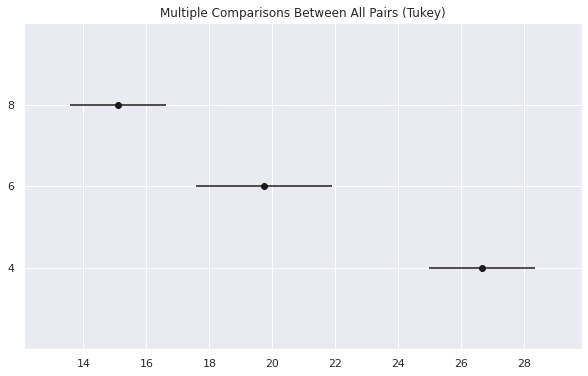

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     4      6  -6.9208 0.0003 -10.7693 -3.0722   True
     4      8 -11.5636    0.0 -14.7708 -8.3565   True
     6      8  -4.6429 0.0112  -8.3276 -0.9581   True
-----------------------------------------------------


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# reject가 True면 PValue가 0.05보다 작음(유의미한 차이가 있다.)
posthoc = pairwise_tukeyhsd(
    endog = df['mpg'], 
    groups = df['cyl'], 
    alpha = 0.05)

#각 그룹 평균의 신뢰구간 도식화
posthoc.plot_simultaneous()
plt.show()

print(posthoc)

## 2) 이원 분산분석
- 종속 1개, 독립 2개

In [ ]:
# am과 cyl에 따라 주행거리(mpg)가 다른지 확인
model = ols('mpg ~ C(am)*C(cyl)', df).fit() # C(am)*C(cyl) == C(am) + C(cyl) + C(am):C(cyl)
am = anova_lm(model, typ=1)

pvalue = am.loc['C(cyl)', 'PR(>F)']
print(f'[shapiro] (H0)평균은 같다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

print(am)

[shapiro] (H0)평균은 같다: False, pvalue = 0.0000
                df      sum_sq     mean_sq          F        PR(>F)
C(am)          1.0  405.150588  405.150588  44.064051  4.846803e-07
C(cyl)         2.0  456.400921  228.200461  24.819011  9.354735e-07
C(am):C(cyl)   2.0   25.436511   12.718256   1.383233  2.686140e-01
Residual      26.0  239.059167    9.194583        NaN           NaN


# ◈ 부호검정

## 1) Run 검정 - 적합도 검정
- 가정된 확률이 정해여 있는 경우, 관찰치의 발생순서가 무작위인지 검정

In [ ]:
from statsmodels.sandbox.stats.runs import Runs

# 맴버십 소지 고객, 비소지 고객의 방문은 무작위로 이뤄졌는가?
x = np.array([1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0])

stat, pvalue = Runs(x).runs_test()
print(f'[Runs] (H0)무작위로 발생: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[Runs] (H0)무작위로 발생: True, pvalue = 0.0676


## 2) Kolmogorov-Smirnov 검정
- 표본의 분포가 가정한 분포와 적합한지 검정

In [ ]:
from statsmodels.stats.diagnostic import kstest_normal

# 설문응답은 정규 분포를 따르는가?
x = np.array(
    [88, 75, 79, 84, 68, 51, 70, 75, 88, 90, 
     92, 88, 63, 72, 94, 80, 78, 98, 81, 67, 
     85, 87, 79, 81, 85, 48, 79, 86, 53, 100, 
     87, 80, 80, 32, 60, 75, 62, 82, 40, 57])

stat, pvalue = kstest_normal(x, dist='norm')
print(f'[kstest_normal] (H0)가정한 분포와 동일: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[kstest_normal] (H0)가정한 분포와 동일: False, pvalue = 0.0079


## 3) Wilcoxon 부호-순위 검정 
- 일표본, 대응표본 동일성 검정(중위수 이용)

In [ ]:
# 일표본 검정
stat, pvalue = stats. wilcoxon(df['mpg']-19.2)
print(f'[wilcoxon] (H0)분포가 동일하다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[wilcoxon] (H0)분포가 동일하다: True, pvalue = 0.7420


In [ ]:
# 대응표본 검정
x = [10, 30, 9, 21, 35, 12, 17, 25, 30, 13]
y = [8, 27, 16, 25, 30, 13, 11, 35, 12, 17]

stat, pvalue = stats.wilcoxon(x, y)
print(f'[wilcoxon] (H0)분포가 동일하다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[wilcoxon] (H0)분포가 동일하다: True, pvalue = 1.0000


## 4) Wilcoxon rank sum 검정 
- 독립표본 동일성 검정(중위수 이용)

In [ ]:
# x와 Y의 중앙 값이 같은가?
x = [10, 30, 9, 21, 35, 12, 17, 25, 30, 13]
y = [8, 27, 16, 25, 30, 13, 11]

stat, pvalue = stats.ranksums(x, y)
print(f'[ranksums] (H0)분포가 동일하다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[ranksums] (H0)분포가 동일하다: True, pvalue = 0.6963


## 5) Mann-Whitney U 검정 
- 독립표본 동일성 검정(평균 이용)

In [ ]:
# 2개 공장간에 생산 효율에 차이가 있는가?
x = [12, 11, 13, 14, 15]
y = [16, 15, 17, 20]

stat, pvalue = stats.mannwhitneyu(x, y)
print(f'[mannwhitneyu] (H0)분포가 동일하다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[mannwhitneyu] (H0)분포가 동일하다: False, pvalue = 0.0268


## 6) Kruskal-Wallis H 검정 
- 독립표본 동일성 검정 - 3개 이상 집단
- 일원분산분석과 유사한 목적

In [ ]:
# 3개 공장의 철근 생산량은 동일한가?
x = [35, 41, 45, 42, 33, 36, 47, 45, 31, 32, 40, 44]
y = [40, 38, 44, 48, 45, 46, 42, 39, 40, 41, 47]
z = [30, 34, 38, 39, 40, 41, 38, 37, 40, 41, 39, 38]

stat, pvalue = stats.kruskal(x, y, z)
print(f'[kruskal] (H0)분포가 동일하다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[kruskal] (H0)분포가 동일하다: False, pvalue = 0.0280


# ◈ 카이제곱 검정 - 범주형
- 교차분석, 분할표에서 빈도를 비교하여 적합도, 독립성, 동질성 검정

## 1) 적합도 검정 
- 일원카이제곱검정
- 하나의 변수에 대해 우리가 기대하는 분포에 따르는지 여부를 검정

In [ ]:
xo, xe = [324,78,261], [371,80,212]

# 일원 카이제곱검정
stat, pvalue = stats.chisquare(xo, f_exp=xe)
print(f'[chisquare] (H0)관찰빈도는 기대빈도와 같다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[chisquare] (H0)관찰빈도는 기대빈도와 같다: False, pvalue = 0.0002


## 2) 독립성 검정 - 이원카이제곱검정
- 두변수가 서로 연관되어 있는지 검정으로 연속형 변수들 사이의 상관분석에 해당
- Contingency 테이블이 있어야 계산 가능
  - 관측도수 = 실제 관측된 데이터
  - 기대도수 = 독립일때 기대되는 도수


In [ ]:
# Contingency Table 생성
df_contingency = pd.crosstab(
    df['am'],
    df['cyl']
    )

# 독립성 검정
chi, pvalue, dof, expected = stats.chi2_contingency(df_contingency, correction=False)
print(f'[chi2_contingency] (H0)두 변수는 독립적이다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

# 상세 결과 출력
print('')
print('기대도수: {}'.format(pd.DataFrame(expected)))
print('')
print('측정도수: {}'.format(df_contingency))

[chi2_contingency] (H0)두 변수는 독립적이다: False, pvalue = 0.0126

기대도수:          0        1       2
0  6.53125  4.15625  8.3125
1  4.46875  2.84375  5.6875

측정도수: cyl  4  6   8
am           
0    3  4  12
1    8  3   2


## 3) 동질성 검정 - 이원카이제곱검정

In [ ]:
# Contingency Table 생성
df_contingency = pd.crosstab(
    df['am'],
    df['cyl']
    )

# 독립성 검정
chi, p, dof, expected = stats.chi2_contingency(df_contingency, correction=False)
print(f'[chi2_contingency] (H0)분포가 동일하다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[chi2_contingency] (H0)분포가 동일하다: False, pvalue = 0.0126


# ◈ 상관분석
- 상관성과 독립성 : 상관성은 선형관계 유무에 대한 기준, 독립성이 더 큰 개념
  - 독립적이다 --> 상관성이 없다 : 성립 O
  - 상관성이 없다 --> 독립적이다 : 성립 x

## 1) Pearson
- 두 연속형 변수간 선형적 증감의 상호관계 표현

In [ ]:
stats.pearsonr(df.mpg, df.disp)

(-0.8475513792624787, 9.380326537381398e-10)

In [ ]:
# Pandas
df.corrwith(df.mpg, method='pearson')

mpg     1.000000
cyl    -0.852162
disp   -0.847551
hp     -0.776168
drat    0.681172
wt     -0.867659
qsec    0.418684
vs      0.664039
am      0.599832
gear    0.480285
carb   -0.550925
dtype: float64

## 2) Spearman
- (비모수적) 두 연속형 변수가 정규분포를 벗어나거나 순위척도일때
- 각 측정값을 순위척도로 변환시켜 한 변수가 증가할때 다른 변수의 증감여부를 계산

In [ ]:
stats.spearmanr(df.am, df.cyl)

SpearmanrResult(correlation=-0.5220711818077189, pvalue=0.0021780464381859397)

In [ ]:
# Pandas
df['cyl'].corr(df.am, method='spearman')

-0.5220711818077188

## 3) Kendall
- (비모수적) 스피머만 상관계수와 비슷하게 순위척도로 변환하여 두 변수간 상관관계 계산

In [ ]:
stats.kendalltau(df.mpg, df.disp)

KendalltauResult(correlation=-0.7681311463779965, pvalue=1.0069500648327088e-09)

In [ ]:
# method = pearson, spearman, kendall
df.corr(method='kendall')

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
mpg,1.000000,-0.795313,-0.768131,-0.742813,0.464549,-0.727832,0.315365,0.589679,0.469013,0.433151,-0.504395
cyl,-0.795313,1.000000,0.814426,0.785186,-0.551318,0.728261,-0.448970,-0.771001,-0.494621,-0.512543,0.465430
disp,-0.768131,0.814426,1.000000,0.665999,-0.498983,0.743382,-0.300815,-0.603306,-0.520274,-0.475980,0.413736
hp,-0.742813,0.785186,0.665999,1.000000,-0.382627,0.611308,-0.472906,-0.630593,-0.303996,-0.279446,0.595984
drat,0.464549,-0.551318,-0.498983,-0.382627,1.000000,-0.547150,0.032722,0.375101,0.575548,0.583925,-0.095352
wt,-0.727832,0.728261,0.743382,0.611308,-0.547150,1.000000,-0.141988,-0.488479,-0.613879,-0.543596,0.371374
qsec,0.315365,-0.448970,-0.300815,-0.472906,0.032722,-0.141988,1.000000,0.657543,-0.168904,-0.091261,-0.506439
vs,0.589679,-0.771001,-0.603306,-0.630593,0.375101,-0.488479,0.657543,1.000000,0.168345,0.269748,-0.576927
am,0.469013,-0.494621,-0.520274,-0.303996,0.575548,-0.613879,-0.168904,0.168345,1.000000,0.770788,-0.058599
gear,0.433151,-0.512543,-0.475980,-0.279446,0.583925,-0.543596,-0.091261,0.269748,0.770788,1.000000,0.098015


## 4) 시각화 - Heatmap

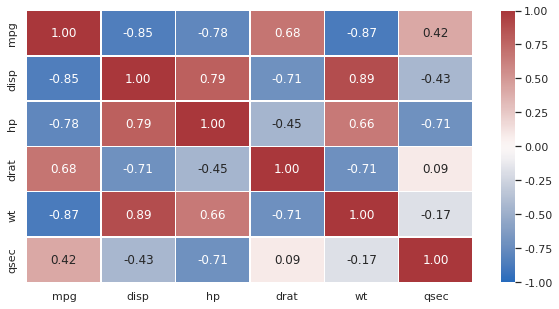

In [ ]:
df = df.astype({'cyl':'category', 'vs':'category', 'am':'category', 'gear':'category', 'carb':'category'})

sns.heatmap(
    data = df.corr(),
    annot = True,
    vmax = 1,
    vmin = -1,
    cmap = 'vlag', # 'RdYlBu_r', 'vlag', 'coolwarm'
    linewidths=.5,
    fmt='.2f'
    );

## 5) 시각화 - Regplot

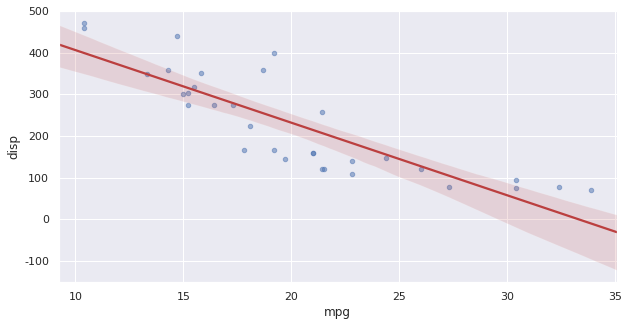

In [ ]:
sns.regplot(
    data = df,
    x = 'mpg',
    y = 'disp',
    # marker ='*', # 마커 : 'o', '*', '+'
    # color = 'green',
    scatter_kws=dict(alpha=0.5, s=20),
    line_kws=dict(color='#bb3f3f'),
    fit_reg = True,
    truncate = False, # 좌우측 여백 유무
    # x_estimator = np.mean, # X 데이터를 CI로 묶어서 표시
    # ci = None, # Confidence Interval : 'sd', 0~100, None
    );

## 6) 시각화 - Pairplot

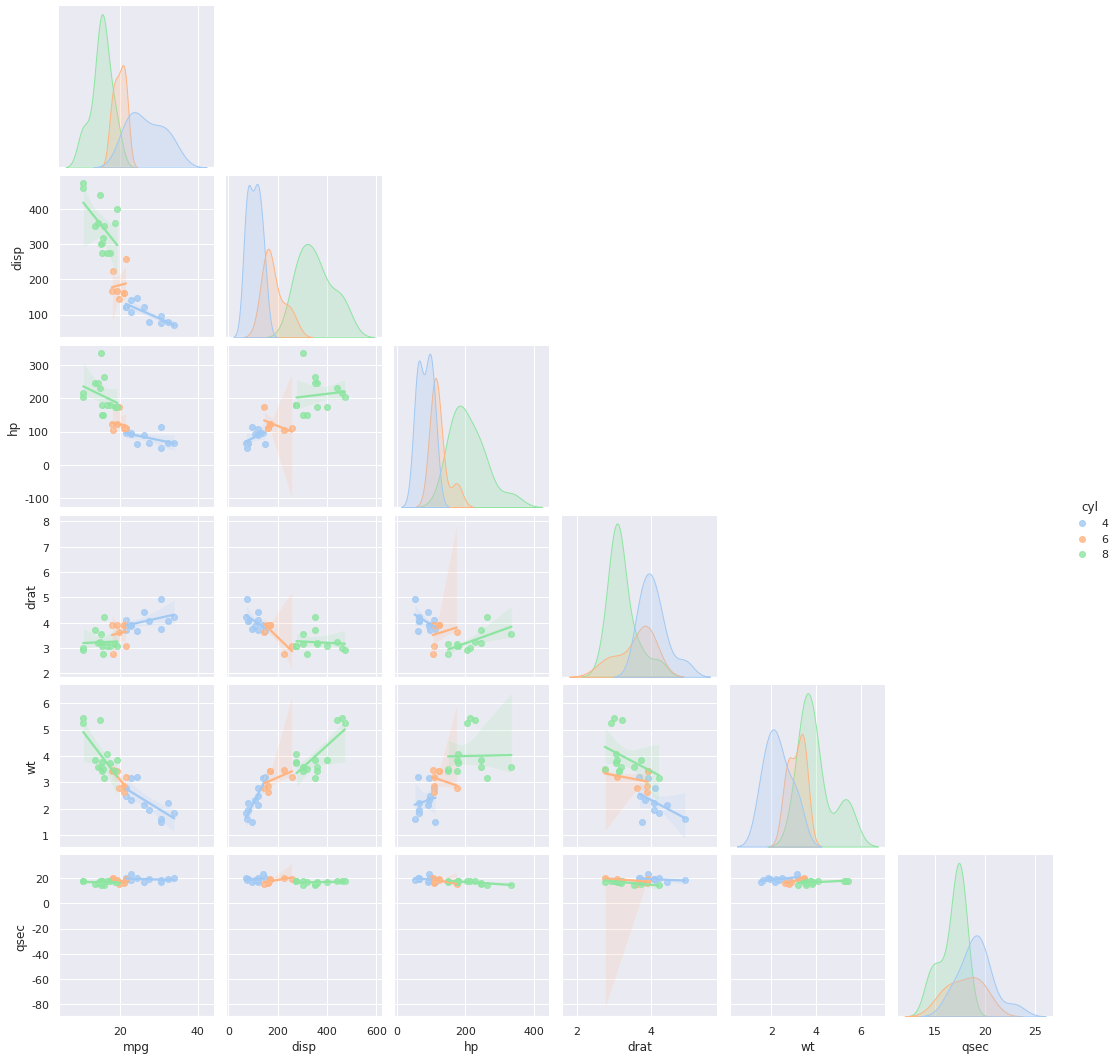

In [ ]:
sns.pairplot(
    data = df,
    hue = 'cyl',
    palette = 'pastel',  # 'vlag', 'pastel', 'Set2'
    kind = 'reg', # 상관관계 그래프 : 'scatter', 'kde', 'hist', 'reg'
    diag_kind = 'kde', # 대각선 그래프 : 'auto', 'hist', 'kde', None
    corner = True,
    # height=2 # 그래프 크기
    );